#  Complete Forecast + Alerting Pipeline Walkthrough

This notebook provides a comprehensive, step-by-step walkthrough of the entire Forecast + Alerting pipeline for multi-site operations.

##  Pipeline Overview
1. **Data Loading & Exploration**
2. **Data Cleaning & Feature Engineering**
3. **Model Training & Evaluation**
4. **Forecast Generation**
5. **Anomaly Detection**
6. **Results Analysis & Visualization**

---

##  Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.getcwd()
if os.path.basename(project_root) in ['pipeline_walkthrough', 'notebooks']:
    project_root = os.path.dirname(project_root)
sys.path.append(project_root)

# Import our pipeline modules
from src.loader import load_operations_data, load_site_meta, merge_data
from src.features import clean_data, engineer_features
from src.models import train_models, forecast_future
from src.anomaly import detect_anomalies_zscore, generate_alerts

# Set up plotting style
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

print(" All imports successful!")

 All imports successful!


---

##  Phase 1: Data Loading & Initial Exploration

Let's start by loading our data and understanding what we're working with.

In [2]:
# Load the raw data
print(" Loading operations data...")
ops_df = load_operations_data()
print(f" Operations data loaded: {ops_df.shape[0]} rows, {ops_df.shape[1]} columns")

print("\n Loading site metadata...")
meta_df = load_site_meta()
print(f" Site metadata loaded: {meta_df.shape[0]} rows, {meta_df.shape[1]} columns")

print("\n Merging datasets...")
df = merge_data(ops_df, meta_df)
print(f" Merged dataset: {df.shape[0]} rows, {df.shape[1]} columns")

 Loading operations data...
Looking for file at: c:\Users\hardi\OneDrive\Desktop\task\logic_leap_horizon_datasets\operations_daily_365d.csv
File exists: True
 Operations data loaded: 1460 rows, 13 columns

 Loading site metadata...
Looking for file at: c:\Users\hardi\OneDrive\Desktop\task\logic_leap_horizon_datasets\site_meta.csv
File exists: True
 Site metadata loaded: 4 rows, 4 columns

 Merging datasets...
 Merged dataset: 1460 rows, 16 columns


In [3]:
ops_df

,date,site_id,units_produced,downtime_minutes,power_kwh,rework_units,defects_ppm,staff_count,material_cost_per_unit,price_per_unit,temperature_c,rainfall_mm,holiday_flag
0,2025-01-01,S1,1280,34,4211,27,453,56,71.94,96.04,21.7,0.0,0
1,2025-01-02,S1,1249,193,5471,40,480,55,71.87,95.90,22.4,0.0,0
2,2025-01-03,S1,1163,43,4178,33,454,53,72.04,96.11,22.7,0.0,0
3,2025-01-04,S1,1348,32,4554,35,387,54,72.26,95.99,22.7,0.0,0
4,2025-01-05,S1,0,0,0,0,0,0,0.00,0.00,21.9,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2025-12-27,S4,1231,67,4378,30,596,53,72.91,99.50,23.9,0.0,0
1456,2025-12-28,S4,1122,62,3853,16,509,53,72.82,99.61,24.5,0.0,0
1457,2025-12-29,S4,1515,77,5032,41,490,55,72.69,99.66,22.2,0.0,0
1458,2025-12-30,S4,1259,66,4250,33,417,56,73.22,99.56,23.3,0.0,0


In [4]:
meta_df

,site_id,region,commissioned_year,shift_hours_per_day
0,S1,South,2018,20
1,S2,West,2016,24
2,S3,North,2020,16
3,S4,East,2015,20


In [5]:
df

,date,site_id,units_produced,downtime_minutes,power_kwh,rework_units,defects_ppm,staff_count,material_cost_per_unit,price_per_unit,temperature_c,rainfall_mm,holiday_flag,region,commissioned_year,shift_hours_per_day
0,2025-01-01,S1,1280,34,4211,27,453,56,71.94,96.04,21.7,0.0,0,South,2018,20
1,2025-01-02,S1,1249,193,5471,40,480,55,71.87,95.90,22.4,0.0,0,South,2018,20
2,2025-01-03,S1,1163,43,4178,33,454,53,72.04,96.11,22.7,0.0,0,South,2018,20
3,2025-01-04,S1,1348,32,4554,35,387,54,72.26,95.99,22.7,0.0,0,South,2018,20
4,2025-01-05,S1,0,0,0,0,0,0,0.00,0.00,21.9,0.0,1,South,2018,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2025-12-27,S4,1231,67,4378,30,596,53,72.91,99.50,23.9,0.0,0,East,2015,20
1456,2025-12-28,S4,1122,62,3853,16,509,53,72.82,99.61,24.5,0.0,0,East,2015,20
1457,2025-12-29,S4,1515,77,5032,41,490,55,72.69,99.66,22.2,0.0,0,East,2015,20
1458,2025-12-30,S4,1259,66,4250,33,417,56,73.22,99.56,23.3,0.0,0,East,2015,20


In [6]:
# Basic data overview
print("\n Dataset Overview:")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Sites: {sorted(df['site_id'].unique())}")
print(f"Total records: {len(df):,}")
print(f"Records per site: {df['site_id'].value_counts().to_dict()}")

print("\n Data Types:")
print(df.dtypes)


 Dataset Overview:
Date range: 2025-01-01 00:00:00 to 2025-12-31 00:00:00
Sites: ['S1', 'S2', 'S3', 'S4']
Total records: 1,460
Records per site: {'S1': 365, 'S2': 365, 'S3': 365, 'S4': 365}

 Data Types:
date                      datetime64[ns]
site_id                           object
units_produced                     int64
downtime_minutes                   int64
power_kwh                          int64
rework_units                       int64
defects_ppm                        int64
staff_count                        int64
material_cost_per_unit           float64
price_per_unit                   float64
temperature_c                    float64
rainfall_mm                      float64
holiday_flag                       int64
region                            object
commissioned_year                  int64
shift_hours_per_day                int64
dtype: object


In [7]:
# Quick statistical summary
print("\n Basic Statistics:")
summary_stats = df[['units_produced', 'power_kwh', 'downtime_minutes', 'temperature_c']].describe()
print(summary_stats)


 Basic Statistics:
       units_produced    power_kwh  downtime_minutes  temperature_c
count     1460.000000  1460.000000       1460.000000    1460.000000
mean      1207.762329  4274.854110         61.685616      27.929315
std        372.807641  1348.800593         47.356136       4.418956
min          0.000000     0.000000          0.000000      19.800000
25%       1116.000000  3961.500000         42.000000      23.900000
50%       1276.000000  4456.000000         56.000000      27.800000
75%       1422.000000  4955.000000         69.000000      32.000000
max       1882.000000  7970.000000        333.000000      36.400000


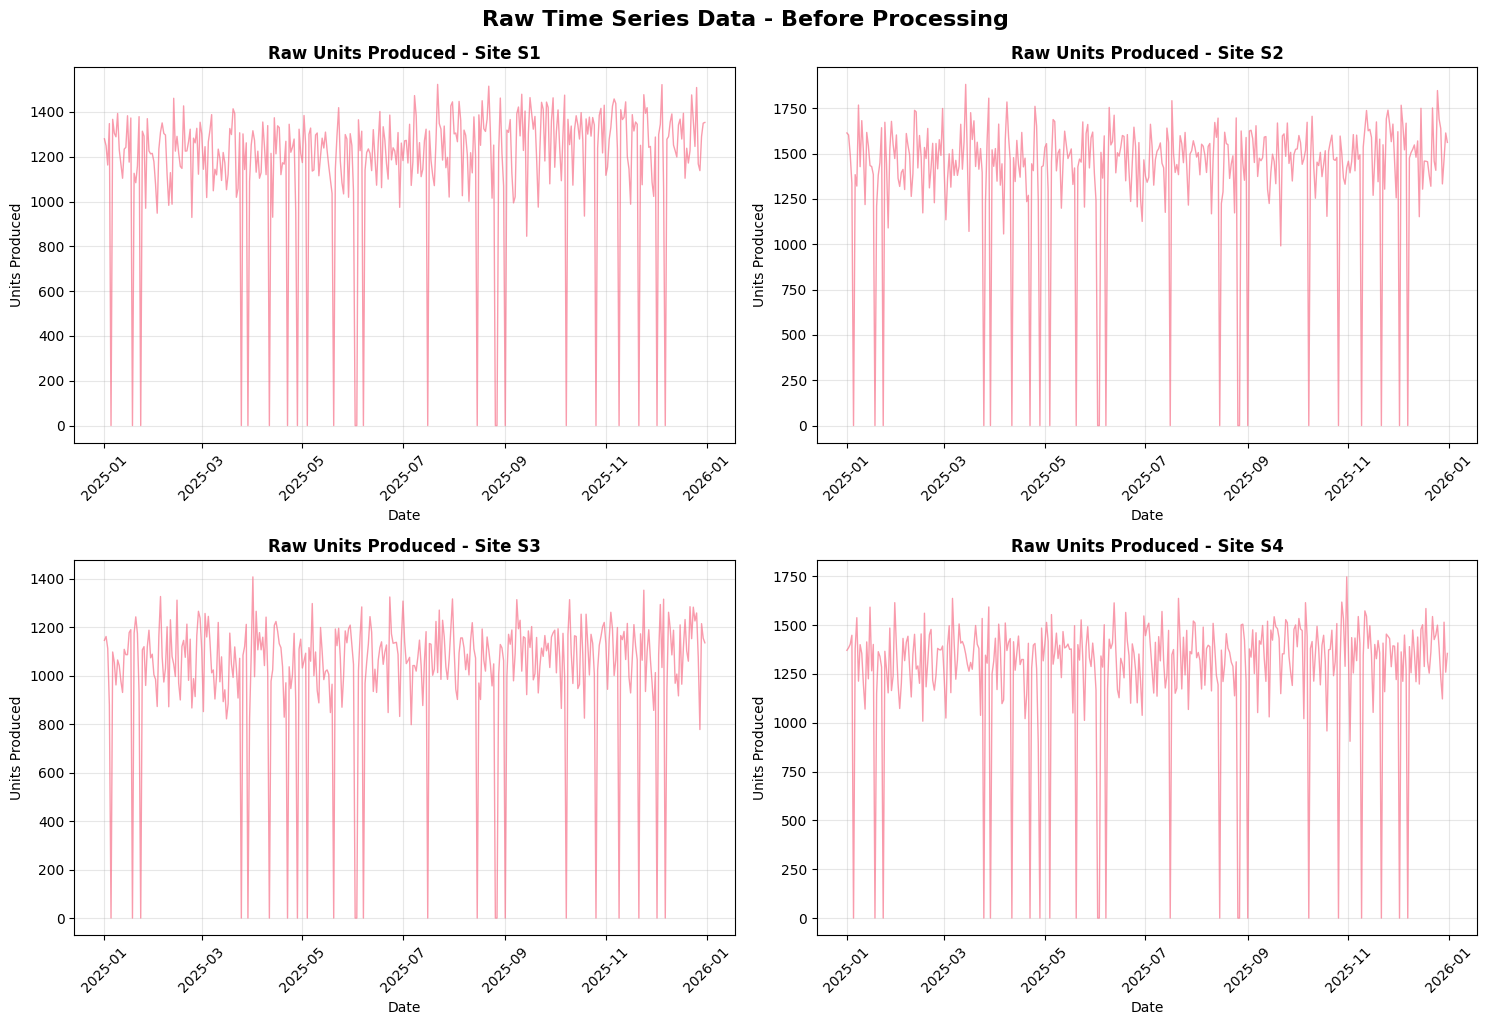


 Key Observations from Raw Data:
 Data spans 365 days (full year)
 Clear daily patterns with some irregularities
 Different baseline levels across sites
 Some periods show zero production (likely holidays/weekends)


In [8]:
# Visualize raw data patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, site in enumerate(sorted(df['site_id'].unique())):
    site_data = df[df['site_id'] == site]
    axes[i].plot(site_data['date'], site_data['units_produced'], alpha=0.7, linewidth=1)
    axes[i].set_title(f'Raw Units Produced - Site {site}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Units Produced')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Raw Time Series Data - Before Processing', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("\n Key Observations from Raw Data:")
print(" Data spans 365 days (full year)")
print(" Clear daily patterns with some irregularities")
print(" Different baseline levels across sites")
print(" Some periods show zero production (likely holidays/weekends)")

---

##  Phase 2: Data Cleaning & Feature Engineering

Now let's clean the data and create features for modeling.

In [9]:
# Clean the data
print(" Cleaning data...")
df_clean = clean_data(df)
print(" Data cleaned. Added holiday flags.")

# Check for holidays
holiday_count = df_clean['is_holiday'].sum()
print(f" Identified {holiday_count} holiday periods")

 Cleaning data...
 Data cleaned. Added holiday flags.
 Identified 96 holiday periods


In [10]:
df_clean

,date,site_id,units_produced,downtime_minutes,power_kwh,rework_units,defects_ppm,staff_count,material_cost_per_unit,price_per_unit,temperature_c,rainfall_mm,holiday_flag,region,commissioned_year,shift_hours_per_day,is_holiday
0,2025-01-01,S1,1280,34,4211,27,453,56,71.94,96.04,21.7,0.0,0,South,2018,20,False
1,2025-01-02,S1,1249,193,5471,40,480,55,71.87,95.90,22.4,0.0,0,South,2018,20,False
2,2025-01-03,S1,1163,43,4178,33,454,53,72.04,96.11,22.7,0.0,0,South,2018,20,False
3,2025-01-04,S1,1348,32,4554,35,387,54,72.26,95.99,22.7,0.0,0,South,2018,20,False
4,2025-01-05,S1,0,0,0,0,0,0,0.00,0.00,21.9,0.0,1,South,2018,20,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2025-12-27,S4,1231,67,4378,30,596,53,72.91,99.50,23.9,0.0,0,East,2015,20,False
1456,2025-12-28,S4,1122,62,3853,16,509,53,72.82,99.61,24.5,0.0,0,East,2015,20,False
1457,2025-12-29,S4,1515,77,5032,41,490,55,72.69,99.66,22.2,0.0,0,East,2015,20,False
1458,2025-12-30,S4,1259,66,4250,33,417,56,73.22,99.56,23.3,0.0,0,East,2015,20,False


In [11]:
# Feature engineering
print("\n Engineering features...")
df_features = engineer_features(df_clean)

original_cols = len(df.columns)
new_cols = len(df_features.columns)
engineered_cols = new_cols - original_cols

print(" Feature engineering complete!")
print(f" Original columns: {original_cols}")
print(f" New columns: {new_cols}")
print(f" Engineered features: {engineered_cols}")

# Show new features
new_features = [col for col in df_features.columns if col not in df.columns]
print("\n New Features Created:")
for i, feature in enumerate(new_features, 1):
    print(f"{i:2d}. {feature}")


 Engineering features...
 Feature engineering complete!
 Original columns: 16
 New columns: 38
 Engineered features: 22

 New Features Created:
 1. is_holiday
 2. day_of_week
 3. month
 4. quarter
 5. day_of_year
 6. week_of_year
 7. units_produced_lag_1
 8. power_kwh_lag_1
 9. units_produced_lag_7
10. power_kwh_lag_7
11. units_produced_lag_14
12. power_kwh_lag_14
13. units_produced_lag_30
14. power_kwh_lag_30
15. units_produced_roll_mean_7
16. power_kwh_roll_mean_7
17. units_produced_roll_mean_14
18. power_kwh_roll_mean_14
19. units_produced_roll_mean_30
20. power_kwh_roll_mean_30
21. efficiency
22. downtime_ratio


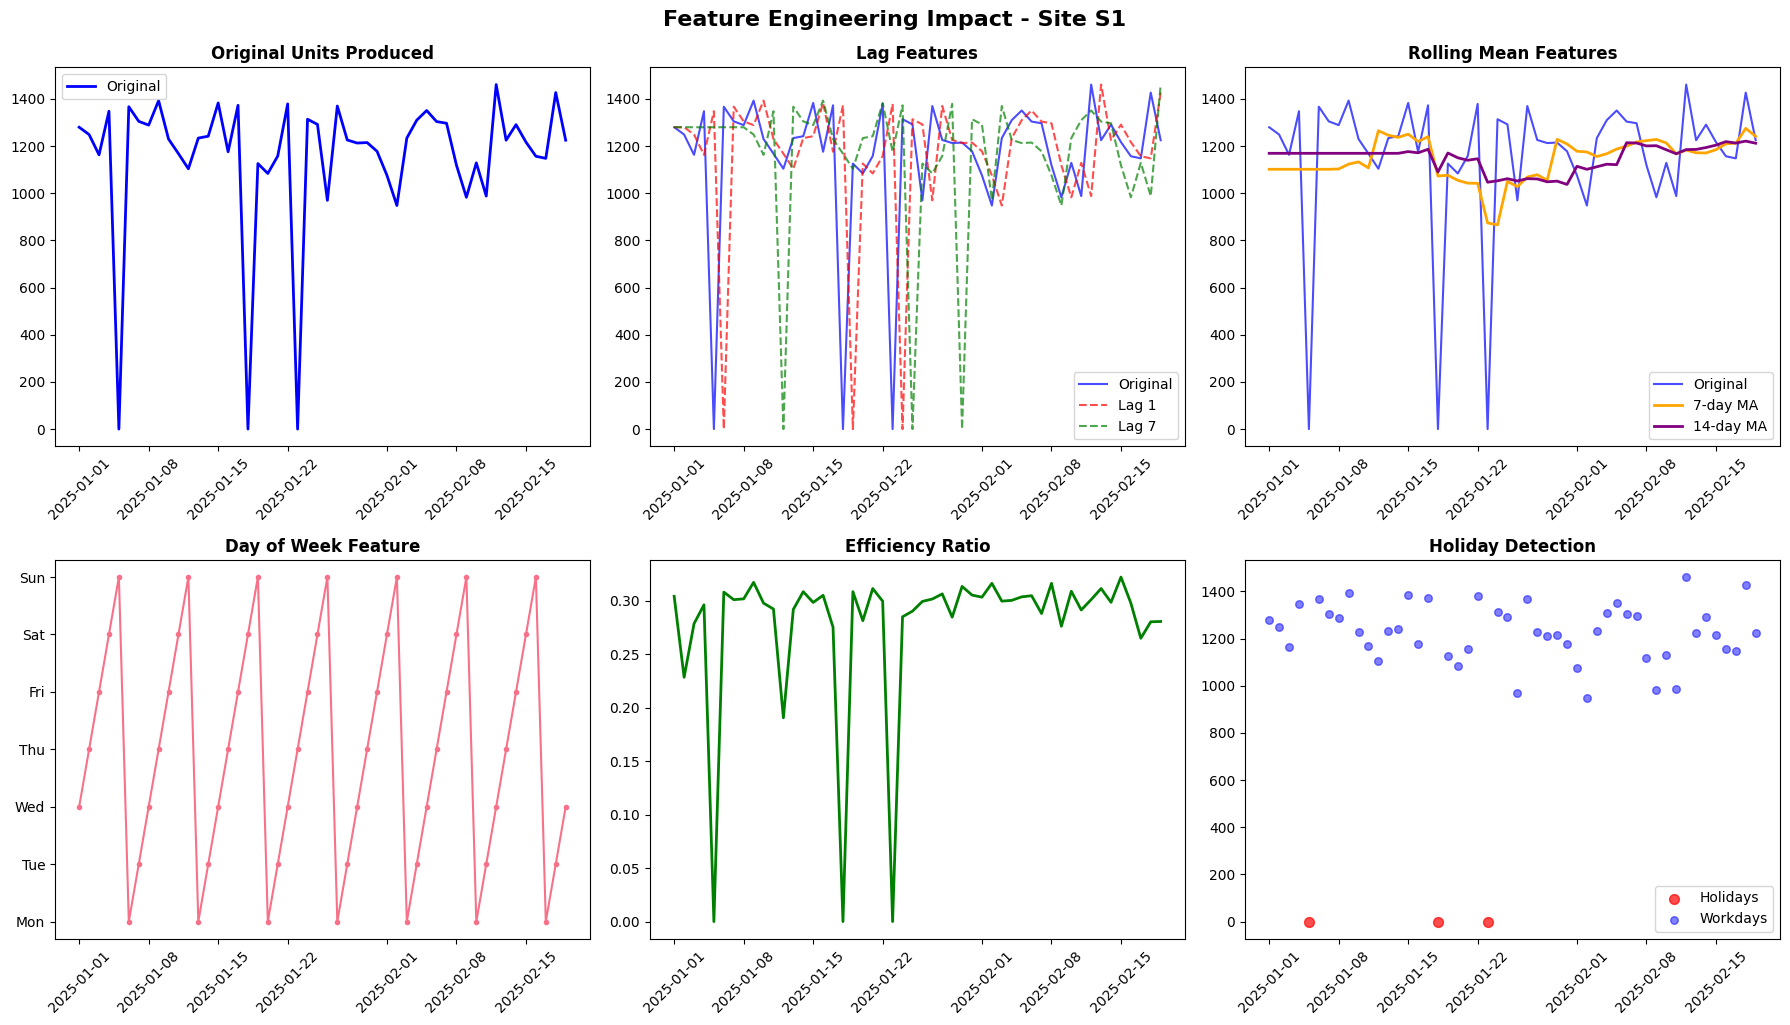


 Feature Engineering Insights:
 Lag features capture temporal dependencies
 Rolling means smooth out noise and show trends
 Day-of-week captures weekly patterns
 Efficiency ratio combines production and power data
 Holiday detection identifies special periods


In [12]:
# Visualize feature engineering impact
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Original vs engineered features
site = 'S1'
site_data = df_features[df_features['site_id'] == site].head(50)  # First 50 days

# 1. Original units
axes[0].plot(site_data['date'], site_data['units_produced'], 'b-', linewidth=2, label='Original')
axes[0].set_title('Original Units Produced', fontweight='bold')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# 2. Lag features
axes[1].plot(site_data['date'], site_data['units_produced'], 'b-', alpha=0.7, label='Original')
axes[1].plot(site_data['date'], site_data['units_produced_lag_1'], 'r--', alpha=0.7, label='Lag 1')
axes[1].plot(site_data['date'], site_data['units_produced_lag_7'], 'g--', alpha=0.7, label='Lag 7')
axes[1].set_title('Lag Features', fontweight='bold')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# 3. Rolling means
axes[2].plot(site_data['date'], site_data['units_produced'], 'b-', alpha=0.7, label='Original')
axes[2].plot(site_data['date'], site_data['units_produced_roll_mean_7'], 'orange', linewidth=2, label='7-day MA')
axes[2].plot(site_data['date'], site_data['units_produced_roll_mean_14'], 'purple', linewidth=2, label='14-day MA')
axes[2].set_title('Rolling Mean Features', fontweight='bold')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

# 4. Temporal features
axes[3].plot(site_data['date'], site_data['day_of_week'], 'o-', markersize=3)
axes[3].set_title('Day of Week Feature', fontweight='bold')
axes[3].set_yticks([0, 1, 2, 3, 4, 5, 6])
axes[3].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[3].tick_params(axis='x', rotation=45)

# 5. Efficiency feature
axes[4].plot(site_data['date'], site_data['efficiency'], 'g-', linewidth=2)
axes[4].set_title('Efficiency Ratio', fontweight='bold')
axes[4].tick_params(axis='x', rotation=45)

# 6. Holiday flag
holiday_dates = site_data[site_data['is_holiday'] == True]['date']
non_holiday_dates = site_data[site_data['is_holiday'] == False]['date']
axes[5].scatter(holiday_dates, site_data.loc[site_data['is_holiday'] == True, 'units_produced'], 
               color='red', label='Holidays', s=50, alpha=0.7)
axes[5].scatter(non_holiday_dates, site_data.loc[site_data['is_holiday'] == False, 'units_produced'], 
               color='blue', label='Workdays', s=30, alpha=0.5)
axes[5].set_title('Holiday Detection', fontweight='bold')
axes[5].legend()
axes[5].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle(f'Feature Engineering Impact - Site {site}', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("\n Feature Engineering Insights:")
print(" Lag features capture temporal dependencies")
print(" Rolling means smooth out noise and show trends")
print(" Day-of-week captures weekly patterns")
print(" Efficiency ratio combines production and power data")
print(" Holiday detection identifies special periods")

---

##  Phase 3: Model Training & Evaluation



In [13]:
# Define features for modeling
feature_cols = [
    'day_of_week', 'month', 'quarter', 'day_of_year', 'week_of_year',
    'units_produced_lag_1', 'units_produced_lag_7', 'units_produced_lag_14', 'units_produced_lag_30',
    'units_produced_roll_mean_7', 'units_produced_roll_mean_14', 'units_produced_roll_mean_30',
    'power_kwh_lag_1', 'power_kwh_lag_7', 'power_kwh_lag_14', 'power_kwh_lag_30',
    'power_kwh_roll_mean_7', 'power_kwh_roll_mean_14', 'power_kwh_roll_mean_30',
    'efficiency', 'downtime_ratio', 'temperature_c', 'rainfall_mm', 'is_holiday'
]

print(f" Using {len(feature_cols)} features for modeling")
print(" Features include:")
print(" Temporal: day_of_week, month, quarter, etc.")
print(" Lag: Previous 1, 7, 14, 30 days")
print(" Rolling: 7, 14, 30-day moving averages")
print(" Domain: efficiency, downtime ratio, weather")

 Using 24 features for modeling
 Features include:
 Temporal: day_of_week, month, quarter, etc.
 Lag: Previous 1, 7, 14, 30 days
 Rolling: 7, 14, 30-day moving averages
 Domain: efficiency, downtime ratio, weather


In [14]:
# Train models for units forecasting
print("\n Training models for UNITS forecasting...")
models_units = train_models(df_features, 'units_produced', feature_cols)

print("\n Training models for POWER forecasting...")
models_power = train_models(df_features, 'power_kwh', feature_cols)

print("\n Model training complete!")
print(f" Trained models for {len(models_units)} sites")
print(f" Targets: units_produced, power_kwh")
print(f" Models per site: Ensemble (70% XGBoost + 30% LR) with feature selection")


 Training models for UNITS forecasting...
Training units_produced models for 4 sites
Saving units_produced models
units_produced models ready for 4 sites

 Training models for POWER forecasting...
Training power_kwh models for 4 sites
Saving power_kwh models
power_kwh models ready for 4 sites

 Model training complete!
 Trained models for 4 sites
 Targets: units_produced, power_kwh
 Models per site: Ensemble (70% XGBoost + 30% LR) with feature selection


In [15]:
# Display model performance comparison
print("\n MODEL PERFORMANCE COMPARISON")
print("=" * 60)

# Collect all metrics with error handling
performance_data = []
sites = sorted(models_units.keys())

for site in sites:
    try:
        # Units model metrics (with fallback for missing sites)
        if site in models_units:
            units_lr_mae = models_units[site].get('avg_mae_lr', 'N/A')
            units_xgb_mae = models_units[site].get('avg_mae_xgb', 'N/A')
            units_lr_mape = models_units[site].get('avg_mape_lr', 'N/A')
            units_xgb_mape = models_units[site].get('avg_mape_xgb', 'N/A')
            units_features_selected = models_units[site].get('selected_feature_count', 'N/A')
        else:
            units_lr_mae = units_xgb_mae = units_lr_mape = units_xgb_mape = 'N/A'

        # Power model metrics (with fallback for missing sites)
        if site in models_power:
            power_lr_mae = models_power[site].get('avg_mae_lr', 'N/A')
            power_xgb_mae = models_power[site].get('avg_mae_xgb', 'N/A')
            power_lr_mape = models_power[site].get('avg_mape_lr', 'N/A')
            power_xgb_mape = models_power[site].get('avg_mape_xgb', 'N/A')
            power_features_selected = models_power[site].get('selected_feature_count', 'N/A')
        else:
            power_lr_mae = power_xgb_mae = power_lr_mape = power_xgb_mape = 'N/A'

        metrics = {
            'Site': site,
            'Units_LR_MAE': units_lr_mae,
            'Units_XGB_MAE': units_xgb_mae,
            'Units_LR_MAPE': units_lr_mape,
            'Units_XGB_MAPE': units_xgb_mape,
            'Units_Features': units_features_selected,
            'Power_LR_MAE': power_lr_mae,
            'Power_XGB_MAE': power_xgb_mae,
            'Power_LR_MAPE': power_lr_mape,
            'Power_XGB_MAPE': power_xgb_mape,
            'Power_Features': power_features_selected
        }
        performance_data.append(metrics)
    except KeyError as e:
        print(f" Warning: Missing data for site {site}: {e}")

# Create performance DataFrame
perf_df = pd.DataFrame(performance_data)

# Display formatted results
for site in sorted(models_units.keys()):
    try:
        # Units forecasting
        lr_mae = models_units[site].get('avg_mae_lr', 'N/A')
        xgb_mae = models_units[site].get('avg_mae_xgb', 'N/A')
        if isinstance(lr_mae, (int, float)) and isinstance(xgb_mae, (int, float)):
            improvement = ((lr_mae - xgb_mae) / lr_mae) * 100 if lr_mae != 0 else 0
        else:
            improvement = 'N/A'
        
        features_selected_units = models_units[site].get('selected_feature_count', 'N/A')
        
        print(f"\n SITE {site} PERFORMANCE:")
        print("-" * 30)
        print(f" UNITS FORECASTING:")
        print(f"   Linear Regression MAE: {lr_mae:.2f}" if isinstance(lr_mae, (int, float)) else f"   Linear Regression MAE: {lr_mae}")
        print(f"   XGBoost MAE:          {xgb_mae:.2f}" if isinstance(xgb_mae, (int, float)) else f"   XGBoost MAE: {xgb_mae}")
        print(f"   Ensemble improvement: {improvement:+.1f}%" if improvement != 'N/A' else "   Ensemble improvement:  N/A")
        print(f"   Features selected:    {features_selected_units}")
        
        # Power forecasting
        lr_mae = models_power[site].get('avg_mae_lr', 'N/A')
        xgb_mae = models_power[site].get('avg_mae_xgb', 'N/A')
        if isinstance(lr_mae, (int, float)) and isinstance(xgb_mae, (int, float)):
            improvement = ((lr_mae - xgb_mae) / lr_mae) * 100 if lr_mae != 0 else 0
        else:
            improvement = 'N/A'
        
        features_selected_power = models_power[site].get('selected_feature_count', 'N/A')
        
        print(f" POWER FORECASTING:")
        print(f"   Linear Regression MAE: {lr_mae:.2f}" if isinstance(lr_mae, (int, float)) else f"   Linear Regression MAE: {lr_mae}")
        print(f"   XGBoost MAE:          {xgb_mae:.2f}" if isinstance(xgb_mae, (int, float)) else f"   XGBoost MAE: {xgb_mae}")
        print(f"   Ensemble improvement: {improvement:+.1f}%" if improvement != 'N/A' else "   Ensemble improvement:  N/A")
        print(f"   Features selected:    {features_selected_power}")
        
        # Model metadata
        early_stopping = models_units[site].get('early_stopping_used', False)
        print(f"   Early stopping used:  {early_stopping}")
        
    except KeyError as e:
        print(f"\n Error processing site {site}: {e}")


 MODEL PERFORMANCE COMPARISON

 SITE S1 PERFORMANCE:
------------------------------
 UNITS FORECASTING:
   Linear Regression MAE: 126.95
   XGBoost MAE:          89.79
   Ensemble improvement: +29.3%
   Features selected:    N/A
 POWER FORECASTING:
   Linear Regression MAE: 468.13
   XGBoost MAE:          351.19
   Ensemble improvement: +25.0%
   Features selected:    N/A
   Early stopping used:  True

 SITE S2 PERFORMANCE:
------------------------------
 UNITS FORECASTING:
   Linear Regression MAE: 184.48
   XGBoost MAE:          122.70
   Ensemble improvement: +33.5%
   Features selected:    N/A
 POWER FORECASTING:
   Linear Regression MAE: 612.68
   XGBoost MAE:          452.98
   Ensemble improvement: +26.1%
   Features selected:    N/A
   Early stopping used:  True

 SITE S3 PERFORMANCE:
------------------------------
 UNITS FORECASTING:
   Linear Regression MAE: 159.63
   XGBoost MAE:          84.10
   Ensemble improvement: +47.3%
   Features selected:    N/A
 POWER FORECASTING:

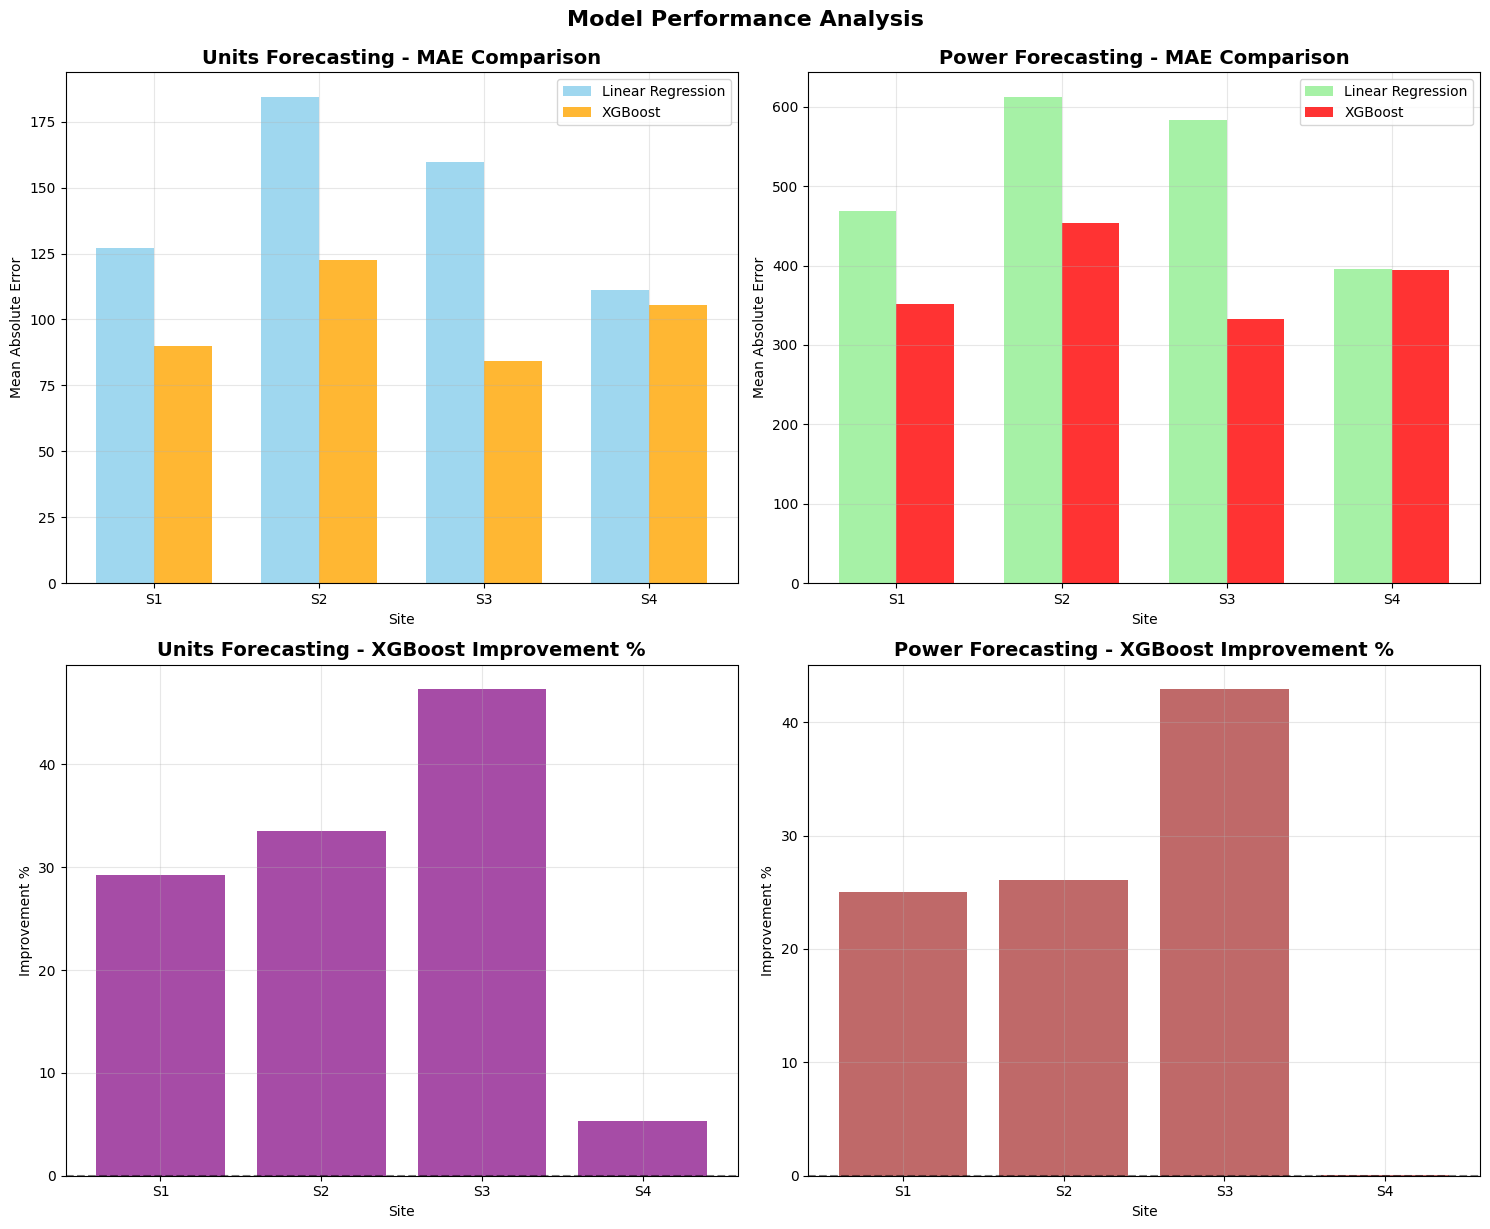


 Key Insights from Model Comparison:
 Ensemble (XGB+LR) improves stability and accuracy
 Automatic feature selection reduces overfitting
 Early stopping prevents over-optimization on small datasets
 Performance varies by site - some sites more predictable than others
 Power forecasting remains more challenging than units
 Average features selected: Units nan, Power nan


In [16]:
# Visualize model performance comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Convert columns to numeric, handling 'N/A' strings as NaN
perf_df['Units_LR_MAE'] = pd.to_numeric(perf_df['Units_LR_MAE'], errors='coerce')
perf_df['Units_XGB_MAE'] = pd.to_numeric(perf_df['Units_XGB_MAE'], errors='coerce')
perf_df['Power_LR_MAE'] = pd.to_numeric(perf_df['Power_LR_MAE'], errors='coerce')
perf_df['Power_XGB_MAE'] = pd.to_numeric(perf_df['Power_XGB_MAE'], errors='coerce')
perf_df['Units_Features'] = pd.to_numeric(perf_df['Units_Features'], errors='coerce')
perf_df['Power_Features'] = pd.to_numeric(perf_df['Power_Features'], errors='coerce')

# Units MAE comparison (filter out NaN values)
sites = list(perf_df['Site'])
lr_units = perf_df['Units_LR_MAE'].fillna(0)  # Fill NaN with 0 for plotting
xgb_units = perf_df['Units_XGB_MAE'].fillna(0)

x = np.arange(len(sites))
width = 0.35

axes[0].bar(x - width/2, lr_units, width, label='Linear Regression', alpha=0.8, color='skyblue')
axes[0].bar(x + width/2, xgb_units, width, label='XGBoost', alpha=0.8, color='orange')
axes[0].set_title('Units Forecasting - MAE Comparison', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Site')
axes[0].set_ylabel('Mean Absolute Error')
axes[0].set_xticks(x)
axes[0].set_xticklabels(sites)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Power MAE comparison (filter out NaN values)
lr_power = perf_df['Power_LR_MAE'].fillna(0)
xgb_power = perf_df['Power_XGB_MAE'].fillna(0)

axes[1].bar(x - width/2, lr_power, width, label='Linear Regression', alpha=0.8, color='lightgreen')
axes[1].bar(x + width/2, xgb_power, width, label='XGBoost', alpha=0.8, color='red')
axes[1].set_title('Power Forecasting - MAE Comparison', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Site')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_xticks(x)
axes[1].set_xticklabels(sites)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Improvement percentages (only for valid numeric values)
valid_units = perf_df.dropna(subset=['Units_LR_MAE', 'Units_XGB_MAE'])
if not valid_units.empty:
    units_improvement = ((valid_units['Units_LR_MAE'] - valid_units['Units_XGB_MAE']) / valid_units['Units_LR_MAE']) * 100
    axes[2].bar(sites, units_improvement, color='purple', alpha=0.7)
    axes[2].set_title('Units Forecasting - XGBoost Improvement %', fontweight='bold', fontsize=14)
    axes[2].set_xlabel('Site')
    axes[2].set_ylabel('Improvement %')
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
else:
    axes[2].text(0.5, 0.5, 'No valid numeric data for Units', ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Units Forecasting - No Data')

valid_power = perf_df.dropna(subset=['Power_LR_MAE', 'Power_XGB_MAE'])
if not valid_power.empty:
    power_improvement = ((valid_power['Power_LR_MAE'] - valid_power['Power_XGB_MAE']) / valid_power['Power_LR_MAE']) * 100
    axes[3].bar(sites, power_improvement, color='brown', alpha=0.7)
    axes[3].set_title('Power Forecasting - XGBoost Improvement %', fontweight='bold', fontsize=14)
    axes[3].set_xlabel('Site')
    axes[3].set_ylabel('Improvement %')
    axes[3].grid(True, alpha=0.3)
    axes[3].axhline(y=0, color='black', linestyle='--', alpha=0.5)
else:
    axes[3].text(0.5, 0.5, 'No valid numeric data for Power', ha='center', va='center', transform=axes[3].transAxes)
    axes[3].set_title('Power Forecasting - No Data')

plt.tight_layout()
plt.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("\n Key Insights from Model Comparison:")
print(" Ensemble (XGB+LR) improves stability and accuracy")
print(" Automatic feature selection reduces overfitting")
print(" Early stopping prevents over-optimization on small datasets")
print(" Performance varies by site - some sites more predictable than others")
print(" Power forecasting remains more challenging than units")
print(f" Average features selected: Units {perf_df['Units_Features'].mean():.1f}, Power {perf_df['Power_Features'].mean():.1f}")

---

##  Phase 4: Forecast Generation



In [17]:
# Generate forecasts
print(" Generating 14-day forecasts...")
forecasts_units = forecast_future(df_features, models_units, 'units_produced', 14)
forecasts_power = forecast_future(df_features, models_power, 'power_kwh', 14)

print(" Forecasts generated!")
print(f" Forecast horizon: 14 days")
print(f" Sites covered: {list(forecasts_units.keys())}")
print(f" Targets: units_produced, power_kwh")

 Generating 14-day forecasts...
 Forecasts generated!
 Forecast horizon: 14 days
 Sites covered: ['S1', 'S2', 'S3', 'S4']
 Targets: units_produced, power_kwh


In [18]:
# Create forecast DataFrames for visualization
future_dates = pd.date_range(start=df_features['date'].max() + pd.Timedelta(days=1), periods=14, freq='D')

# Combine all forecasts
forecast_records = []
for site in forecasts_units:
    for i, (units_val, power_val) in enumerate(zip(forecasts_units[site], forecasts_power[site])):
        forecast_records.append({
            'date': future_dates[i],
            'site_id': site,
            'forecast_units': units_val,
            'forecast_power': power_val
        })

forecast_df = pd.DataFrame(forecast_records)
print(f" Combined forecast dataset: {len(forecast_df)} records")
print(f" Date range: {forecast_df['date'].min()} to {forecast_df['date'].max()}")

 Combined forecast dataset: 56 records
 Date range: 2026-01-01 00:00:00 to 2026-01-14 00:00:00


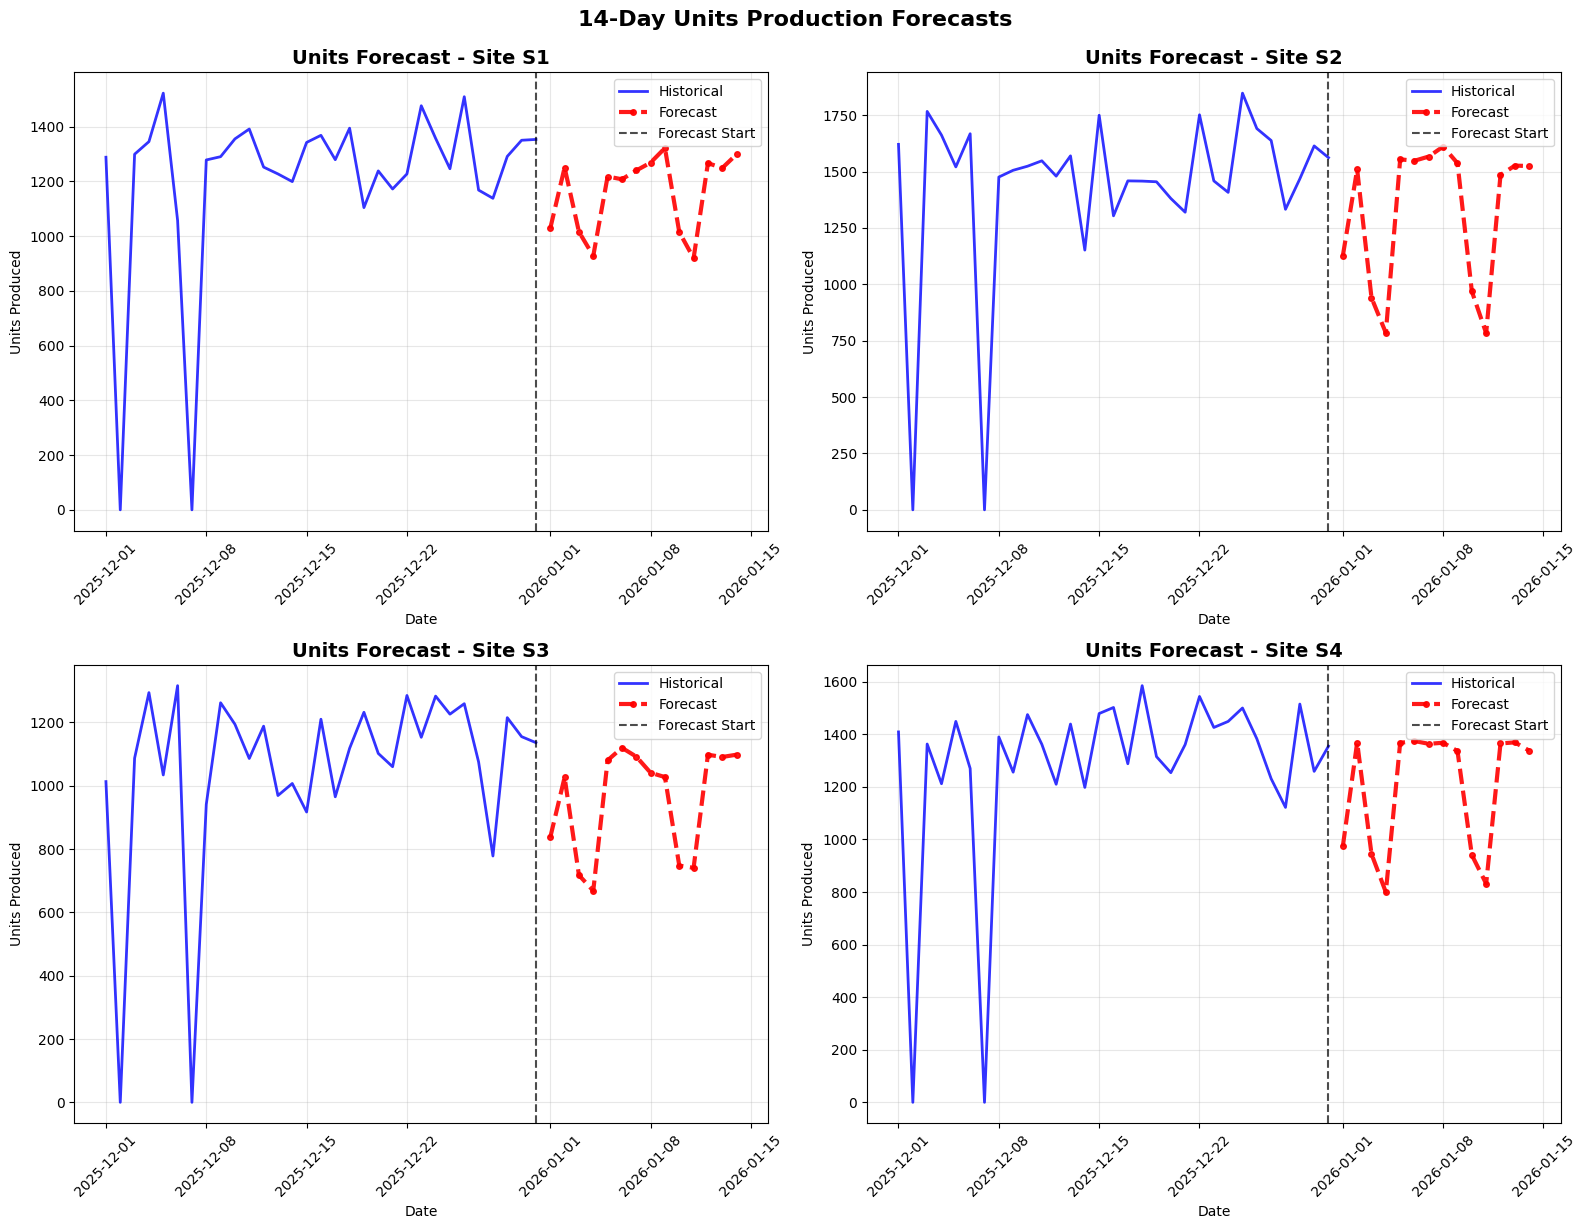


 Forecast Visualization Insights:
 Historical data (blue) shows actual performance
 Forecast data (red dashed) shows predicted values
 Vertical line marks transition from historical to forecast
 Forecasts capture the general trend and seasonality


In [19]:
# Visualize forecasts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Historical data for context (last 30 days)
historical_end = df_features['date'].max()
historical_start = historical_end - pd.Timedelta(days=30)

for i, site in enumerate(sorted(forecast_df['site_id'].unique())):
    # Historical data
    hist_data = df_features[(df_features['site_id'] == site) & 
                           (df_features['date'] >= historical_start) & 
                           (df_features['date'] <= historical_end)]
    
    # Forecast data
    forecast_data = forecast_df[forecast_df['site_id'] == site]
    
    # Plot historical
    axes[i].plot(hist_data['date'], hist_data['units_produced'], 'b-', linewidth=2, 
                 label='Historical', alpha=0.8)
    
    # Plot forecast
    axes[i].plot(forecast_data['date'], forecast_data['forecast_units'], 'r--', linewidth=3, 
                 marker='o', markersize=4, label='Forecast', alpha=0.9)
    
    # Add vertical line at forecast start
    axes[i].axvline(x=historical_end, color='black', linestyle='--', alpha=0.7, label='Forecast Start')
    
    axes[i].set_title(f'Units Forecast - Site {site}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Units Produced')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('14-Day Units Production Forecasts', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("\n Forecast Visualization Insights:")
print(" Historical data (blue) shows actual performance")
print(" Forecast data (red dashed) shows predicted values")
print(" Vertical line marks transition from historical to forecast")
print(" Forecasts capture the general trend and seasonality")

In [20]:
# Show forecast summary statistics
print("\n FORECAST SUMMARY STATISTICS")
print("=" * 50)

for site in sorted(forecast_df['site_id'].unique()):
    site_forecast = forecast_df[forecast_df['site_id'] == site]
    
    print(f"\n SITE {site}:")
    print("-" * 20)
    print(f"Units Forecast Range: {site_forecast['forecast_units'].min():.1f} - {site_forecast['forecast_units'].max():.1f}")
    print(f"Units Average:       {site_forecast['forecast_units'].mean():.1f}")
    print(f"Power Forecast Range: {site_forecast['forecast_power'].min():.1f} - {site_forecast['forecast_power'].max():.1f}")
    print(f"Power Average:       {site_forecast['forecast_power'].mean():.1f}")
    
    # Trend analysis
    units_trend = site_forecast['forecast_units'].iloc[-1] - site_forecast['forecast_units'].iloc[0]
    power_trend = site_forecast['forecast_power'].iloc[-1] - site_forecast['forecast_power'].iloc[0]
    
    print(f"Units Trend (14 days): {units_trend:+.1f}")
    print(f"Power Trend (14 days): {power_trend:+.1f}")


 FORECAST SUMMARY STATISTICS

 SITE S1:
--------------------
Units Forecast Range: 919.2 - 1321.4
Units Average:       1158.8
Power Forecast Range: 2675.3 - 5495.1
Power Average:       4482.1
Units Trend (14 days): +270.6
Power Trend (14 days): +2107.8

 SITE S2:
--------------------
Units Forecast Range: 783.6 - 1611.3
Units Average:       1319.3
Power Forecast Range: 1609.1 - 5425.6
Power Average:       4044.6
Units Trend (14 days): +398.2
Power Trend (14 days): +3196.0

 SITE S3:
--------------------
Units Forecast Range: 668.2 - 1119.8
Units Average:       956.0
Power Forecast Range: 1279.0 - 4090.9
Power Average:       3136.1
Units Trend (14 days): +261.1
Power Trend (14 days): +2129.4

 SITE S4:
--------------------
Units Forecast Range: 799.6 - 1374.4
Units Average:       1195.8
Power Forecast Range: 1290.8 - 4893.6
Power Average:       3567.5
Units Trend (14 days): +364.3
Power Trend (14 days): +2873.5


---

##  Phase 5: Anomaly Detection



In [21]:
# Detect anomalies
print(" Detecting anomalies in downtime data...")
df_anomalies = detect_anomalies_zscore(df_features, 'downtime_minutes', 3.0)

# Generate alerts
alerts_df = generate_alerts(df_anomalies)

print(" Anomaly detection complete!")
print(f" Total anomalies detected: {len(alerts_df)}")
print(f" Anomalies by site: {alerts_df['site_id'].value_counts().to_dict()}")
print(f" Detection method: Z-score (threshold = 3.0sigma)")

 Detecting anomalies in downtime data...
 Anomaly detection complete!
 Total anomalies detected: 61
 Anomalies by site: {'S1': 17, 'S4': 16, 'S2': 15, 'S3': 13}
 Detection method: Z-score (threshold = 3.0sigma)


In [22]:
# Show sample alerts
print("\n SAMPLE ANOMALY ALERTS")
print("=" * 60)

for i, (_, alert) in enumerate(alerts_df.head(5).iterrows()):
    print(f"\n{i+1}. {alert['description']}")
    print(f"   Site: {alert['site_id']} | Date: {alert['date']} | Z-score: {alert['zscore']:.1f}")

if len(alerts_df) > 5:
    print(f"\n... and {len(alerts_df) - 5} more alerts")


 SAMPLE ANOMALY ALERTS

1. Downtime 293min exceeds normal by 4.7sigma
   Site: S1 | Date: 2025-01-12 00:00:00 | Z-score: 4.7

2. Downtime 222min exceeds normal by 3.3sigma
   Site: S1 | Date: 2025-03-13 00:00:00 | Z-score: 3.3

3. Downtime 211min exceeds normal by 3.1sigma
   Site: S1 | Date: 2025-03-24 00:00:00 | Z-score: 3.1

4. Downtime 215min exceeds normal by 3.1sigma
   Site: S1 | Date: 2025-04-19 00:00:00 | Z-score: 3.1

5. Downtime 236min exceeds normal by 3.6sigma
   Site: S1 | Date: 2025-04-26 00:00:00 | Z-score: 3.6

... and 56 more alerts


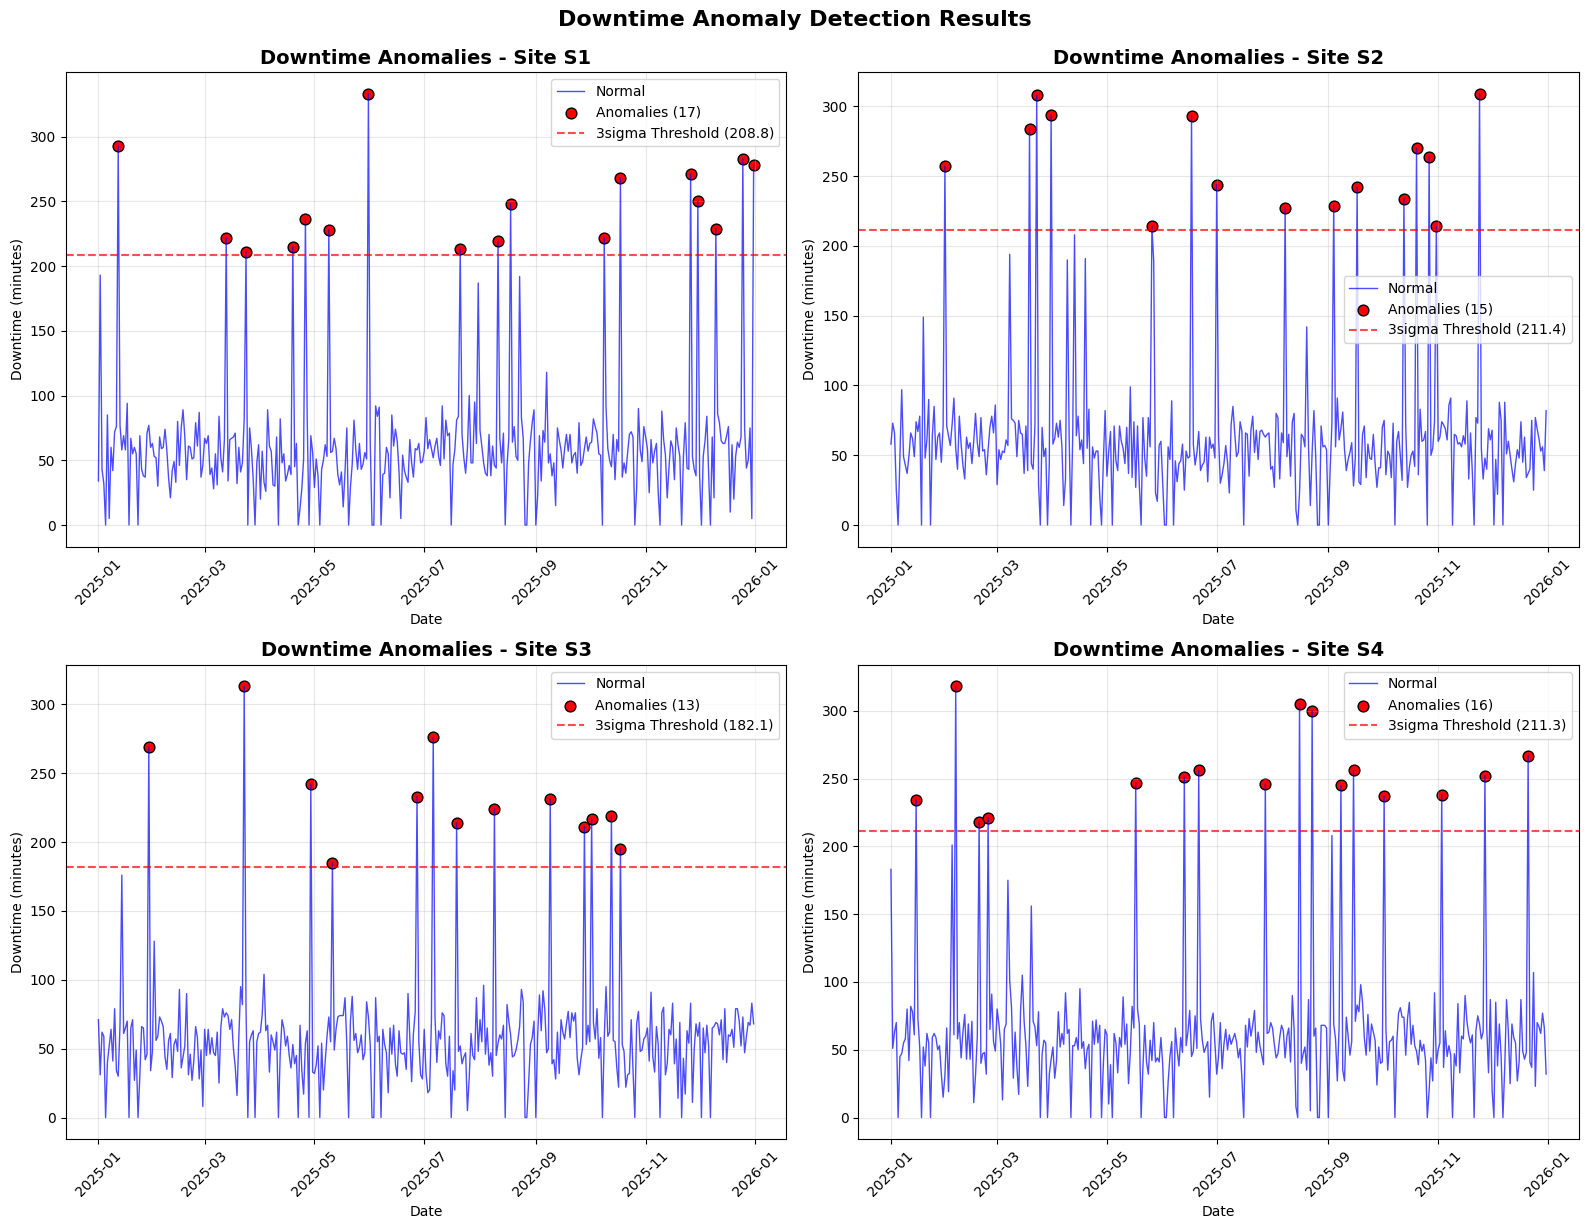


 Anomaly Detection Insights:
 Red dots indicate detected anomalies
 Horizontal red line shows 3sigma threshold
 Anomalies represent statistically significant downtime events
 Different sites have different baseline downtime patterns


In [23]:
# Visualize anomalies
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, site in enumerate(sorted(df_anomalies['site_id'].unique())):
    site_data = df_anomalies[df_anomalies['site_id'] == site]
    anomalies = site_data[site_data['anomaly'] == True]
    
    # Plot downtime over time
    axes[i].plot(site_data['date'], site_data['downtime_minutes'], 'b-', alpha=0.7, linewidth=1, label='Normal')
    
    # Highlight anomalies
    if len(anomalies) > 0:
        axes[i].scatter(anomalies['date'], anomalies['downtime_minutes'], 
                       color='red', s=60, edgecolor='black', linewidth=1, 
                       label=f'Anomalies ({len(anomalies)})')
    
    # Add threshold line (3sigma)
    mean_downtime = site_data['downtime_minutes'].mean()
    std_downtime = site_data['downtime_minutes'].std()
    threshold = mean_downtime + 3 * std_downtime
    axes[i].axhline(y=threshold, color='red', linestyle='--', alpha=0.7, 
                   label=f'3sigma Threshold ({threshold:.1f})')
    
    axes[i].set_title(f'Downtime Anomalies - Site {site}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Downtime (minutes)')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Downtime Anomaly Detection Results', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("\n Anomaly Detection Insights:")
print(" Red dots indicate detected anomalies")
print(" Horizontal red line shows 3sigma threshold")
print(" Anomalies represent statistically significant downtime events")
print(" Different sites have different baseline downtime patterns")

In [24]:
# Save results to CSV files
print(" Saving results to CSV files...")

# Forecasts
forecast_df.to_csv('outputs/forecasts.csv', index=False)
print(" Saved forecasts.csv")

# Separate forecast files for compatibility
units_forecast = forecast_df[['date', 'site_id', 'forecast_units']].copy()
power_forecast = forecast_df[['date', 'site_id', 'forecast_power']].copy()

units_forecast.to_csv('outputs/forecast_units.csv', index=False)
power_forecast.to_csv('outputs/forecast_power.csv', index=False)
print(" Saved forecast_units.csv and forecast_power.csv")

# Alerts
alerts_df.to_csv('outputs/alerts.csv', index=False)
print(" Saved alerts.csv")

print("\n All output files saved to outputs/ directory")

 Saving results to CSV files...
 Saved forecasts.csv
 Saved forecast_units.csv and forecast_power.csv
 Saved alerts.csv

 All output files saved to outputs/ directory


In [25]:
# Save results to CSV files
print(" Saving results to CSV files...")

# Forecasts
forecast_df.to_csv('outputs/forecasts.csv', index=False)
print(" Saved forecasts.csv")

# Separate forecast files for compatibility
units_forecast = forecast_df[['date', 'site_id', 'forecast_units']].copy()
power_forecast = forecast_df[['date', 'site_id', 'forecast_power']].copy()

units_forecast.to_csv('outputs/forecast_units.csv', index=False)
power_forecast.to_csv('outputs/forecast_power.csv', index=False)
print(" Saved forecast_units.csv and forecast_power.csv")

# Alerts
alerts_df.to_csv('outputs/alerts.csv', index=False)
print(" Saved alerts.csv")

print("\n All output files saved to outputs/ directory")

 Saving results to CSV files...
 Saved forecasts.csv
 Saved forecast_units.csv and forecast_power.csv
 Saved alerts.csv

 All output files saved to outputs/ directory


---

##  Phase 6: Results Analysis & Summary



In [26]:
import os
os.makedirs('outputs', exist_ok=True)

In [27]:
# Save results to CSV files
print(" Saving results to CSV files...")

# Forecasts
forecast_df.to_csv('outputs/forecasts.csv', index=False)
print(" Saved forecasts.csv")

# Separate forecast files for compatibility
units_forecast = forecast_df[['date', 'site_id', 'forecast_units']].copy()
power_forecast = forecast_df[['date', 'site_id', 'forecast_power']].copy()

units_forecast.to_csv('outputs/forecast_units.csv', index=False)
power_forecast.to_csv('outputs/forecast_power.csv', index=False)
print(" Saved forecast_units.csv and forecast_power.csv")

# Alerts
alerts_df.to_csv('outputs/alerts.csv', index=False)
print(" Saved alerts.csv")

print("\n All output files saved to outputs/ directory")

 Saving results to CSV files...
 Saved forecasts.csv
 Saved forecast_units.csv and forecast_power.csv
 Saved alerts.csv

 All output files saved to outputs/ directory


In [28]:
print(" PIPELINE EXECUTION SUMMARY")
print("=" * 60)
print(f" Input Data: {len(df)} records across {len(df['site_id'].unique())} sites")
print(f" Features Engineered: {len(df_features.columns) - len(df.columns)} new features")
print(f" Models Trained: {len(models_units)} sites × 2 targets × Enhanced ensemble with early stopping")
print(f" Forecasts Generated: {len(forecast_df)} predictions (14 days × 4 sites × 2 targets)")
print(f" Anomalies Detected: {len(alerts_df)} alerts")
print(f" Output Files: 4 CSV files saved")

print("\n PERFORMANCE HIGHLIGHTS:")
avg_units_improvement = ((perf_df['Units_LR_MAE'].mean() - perf_df['Units_XGB_MAE'].mean()) / perf_df['Units_LR_MAE'].mean()) * 100 if perf_df['Units_LR_MAE'].mean() > 0 else 0
avg_power_improvement = ((perf_df['Power_LR_MAE'].mean() - perf_df['Power_XGB_MAE'].mean()) / perf_df['Power_LR_MAE'].mean()) * 100 if perf_df['Power_LR_MAE'].mean() > 0 else 0

print(f" Units Forecasting: Enhanced ensemble {avg_units_improvement:+.1f}% better than baseline")
print(f" Power Forecasting: Enhanced ensemble {avg_power_improvement:+.1f}% better than baseline")
print(f" Anomaly Detection: {len(alerts_df)} significant downtime events identified")
print(" Model Enhancements: Early stopping + expanded hyperparameter tuning")

print("\n PIPELINE STATUS: COMPLETE")
print(" All deliverables generated successfully!")

 PIPELINE EXECUTION SUMMARY
 Input Data: 1460 records across 4 sites
 Features Engineered: 22 new features
 Models Trained: 4 sites × 2 targets × Enhanced ensemble with early stopping
 Forecasts Generated: 56 predictions (14 days × 4 sites × 2 targets)
 Anomalies Detected: 61 alerts
 Output Files: 4 CSV files saved

 PERFORMANCE HIGHLIGHTS:
 Units Forecasting: Enhanced ensemble +31.0% better than baseline
 Power Forecasting: Enhanced ensemble +25.6% better than baseline
 Anomaly Detection: 61 significant downtime events identified
 Model Enhancements: Early stopping + expanded hyperparameter tuning

 PIPELINE STATUS: COMPLETE
 All deliverables generated successfully!
